In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, r2_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
from sklearn.cluster import KMeans, DBSCAN

In [3]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'Spotify_Dataset_V3.csv')
df = pd.read_csv(data_path, delimiter=';')
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df["Day_in_week"] = df["Date"].dt.dayofweek
df["Month"] = df["Date"].dt.month
df.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL,Day_in_week,Month
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,0,5
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,0,5
2,2,WHERE SHE GOES,Bad Bunny,2023-05-29,0.652,0.800,-4019.0,0.061,0.143,0.629,...,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...,0,5
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,0,5
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,0,5


# Data Preparation

In [4]:
# Clean - Drop Duplicates
df_clean = df.drop_duplicates(subset=["Date", "id"], keep="last").copy()
df_clean.shape

(467061, 22)

In [5]:
# Filtering out songs that appears less than 14 days
df_appear_count = df_clean.groupby('id').size().reset_index(name='count')
ids_to_be_used = df_appear_count[df_appear_count["count"] > 14]["id"]
df_clean = df_clean[df_clean["id"].isin(ids_to_be_used)]
df_clean.shape

(445363, 22)

In [6]:
# Filtering out songs that first appears recently
df_min_date = df_clean.groupby('id')["Date"].min().reset_index(name='Date')
ids_to_be_used = df_min_date[df_min_date["Date"] < "2023-01-01"]["id"]
df_clean = df_clean[df_clean["id"].isin(ids_to_be_used)]
df_clean.shape

(437075, 22)

### Day Since Appear

In [7]:
df_points = df_clean[["Points (Total)", "Date", "id"]].copy()
# df_points = df_points[:100000].copy()

# Calculate Day Since Appear
# df_points.sort_values(by=['id', 'Date'], inplace=True)
df_points['day_since_appear'] = df_points.groupby('id')['Date'].transform(lambda x: (x - x.min()).dt.days + 1)

In [8]:
# df_points['Points (Total)'] = pd.cut(df_points["Points (Total)"], bins=10, labels=range(1, 11)).astype(int)

### Fill in 0 for missing "Points (Total)"

In [9]:
day_since_appear = pd.Series(range(1,df_points['day_since_appear'].max()))
uuids = df_points["id"].unique()

all_combinations = pd.MultiIndex.from_product([uuids, day_since_appear], names=['id', 'day_since_appear'])
full_df = pd.DataFrame(index=all_combinations).reset_index()

merged_df = pd.merge(full_df, df_points, on=['id', 'day_since_appear'], how='left')
merged_df['Points (Total)'].fillna(0, inplace=True)
merged_df.head()

,id,day_since_appear,Points (Total),Date
0,1Qrg8KqiBpW07V7PNxwwwL,1,196.0,2022-12-09
1,1Qrg8KqiBpW07V7PNxwwwL,2,193.0,2022-12-10
2,1Qrg8KqiBpW07V7PNxwwwL,3,194.0,2022-12-11
3,1Qrg8KqiBpW07V7PNxwwwL,4,199.0,2022-12-12
4,1Qrg8KqiBpW07V7PNxwwwL,5,200.0,2022-12-13


In [10]:
# Random song & Plot Popularity over time
# plt.figure(figsize=(10,3))
# sample = merged_df.sample(n=1).iloc[0]
# sns.lineplot(merged_df[merged_df["id"] == sample["id"]], x="day_since_appear", y="Points (Total)")

In [11]:
# Pivot the DataFrame for clustering
pivot_df = merged_df.pivot(index='id', columns='day_since_appear', values='Points (Total)')
pivot_df.head()

day_since_appear,1,2,3,4,5,6,7,8,9,10,...,2330,2331,2332,2333,2334,2335,2336,2337,2338,2339
id,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,151.0,133.0,134.0,153.0,158.0,161.0,160.0,154.0,152.0,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003vvx7Niy0yvhvHt4a68B,6.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00Blm7zeNqgYLPtW6zg8cj,193.0,191.0,189.0,194.0,192.0,192.0,190.0,182.0,184.0,185.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00EPIEnX1JFjff8sC6bccd,11.0,24.0,31.0,44.0,60.0,59.0,57.0,70.0,81.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00ko9WaS4jOX1kEk3gvHjf,96.0,156.0,146.0,146.0,127.0,112.0,99.0,71.0,62.0,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Smoothout the data by using week average
pivot_df = pivot_df.apply(lambda row: row.rolling(window=7, step=7, min_periods=1).mean(), axis=1)

In [13]:
# Normalize data
pivot_df_norm = pivot_df.T
# pivot_df_norm = (pivot_df_norm-pivot_df_norm.mean())/pivot_df_norm.std()
pivot_df_norm = (pivot_df_norm-pivot_df_norm.min()) / (pivot_df_norm.max()-pivot_df_norm.min())
pivot_df_norm = pivot_df_norm.T
pivot_df_norm.head()

day_since_appear,1,8,15,22,29,36,43,50,57,64,...,2276,2283,2290,2297,2304,2311,2318,2325,2332,2339
id,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,0.996230,0.992460,1.000000,0.969840,0.898209,0.951932,0.951932,0.917059,0.872762,0.839774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003vvx7Niy0yvhvHt4a68B,0.086598,0.026804,0.014433,0.028866,0.002062,0.004124,0.000000,0.000000,0.016495,0.014433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00Blm7zeNqgYLPtW6zg8cj,1.000000,0.984456,0.958549,0.934123,0.892672,0.792006,0.786084,0.660252,0.741673,0.856403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00EPIEnX1JFjff8sC6bccd,0.083696,0.375000,0.686957,0.685870,0.813043,0.871739,0.998913,1.000000,0.996739,0.961957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00ko9WaS4jOX1kEk3gvHjf,0.784131,1.000000,0.358226,0.001167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# pivot_df.to_csv("date_point_pop_only.csv")

In [15]:
# # Calculate Differentitate
# df_diff_0 = pivot_df.diff(axis=1)
# df_diff_0.drop(columns=1, inplace=True)
# # df_diff_0.head()

# # 2nd Differentitate
# # df_diff = df_diff_0.diff(axis=1)
# # df_diff.drop(columns=2, inplace=True)
# # df_diff.head()

# # Normalize by min-max
# # df_diff_0 = df_diff_0.T
# # df_diff = (df_diff_0-df_diff_0.min())/(df_diff_0.max()-df_diff_0.min())
# # df_diff = df_diff.T

# df_diff = df_diff_0
# df_diff.head()

<Axes: xlabel='day_since_appear', ylabel='7iAgNZdotu40NwtoIWJHFe'>

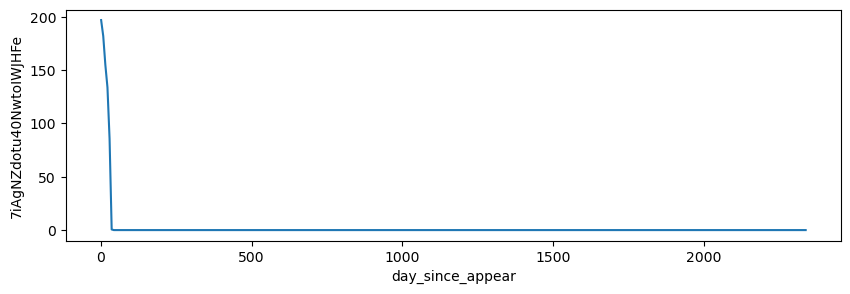

In [16]:
sample = pivot_df.sample(n=1)
sample_id = sample.index[0]

plt.figure(figsize=(10,3))
sns.lineplot(sample.iloc[0])

# plt.show()
# plt.figure(figsize=(10,3))
# sns.lineplot(df_diff.loc[sample_id])

# Song Popularity Over time

In [17]:
# all time hit, 6RUKPb4LETWmmr3iAEQktW, 5uCax9HTNlzGybIStD3vDh
# old release, but popular in 2022, 4xkOaSrkexMciUUogZKVTS, 4UKCKdYiLN6IMA5ZESUTL7, 1kKYjjfNYxE0YYgLa7vgVY
# popu. on and off, 2jyjhRf6DVbMPU5zxagN2h, 60a0Rd6pjrkxjPbaKzXjfq
# popu. on festival, 2TE4xW3ImvpltVU0cPcKUn, 15coTBAzEN1bOeipoNDZAR

id: 1HhNoOuqm1a5MXYEgAFl8o | Total count: 154
Song: Enemy (with JID) - from the series Arcane League of Legends | Artists: Imagine Dragons, JID, Arcane, League of Legends | Continent: Anglo-America


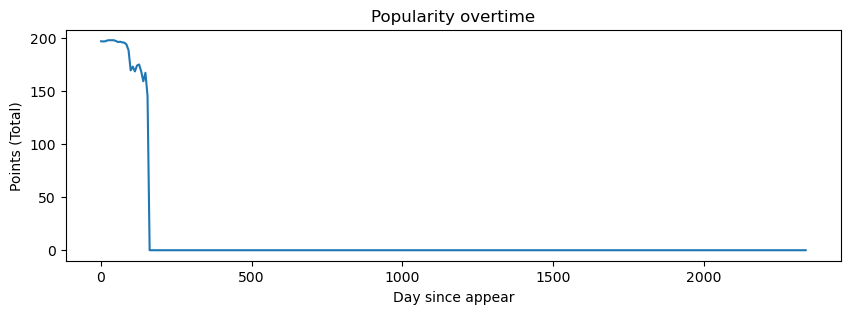

Text(0.5, 0, 'Day since appear')

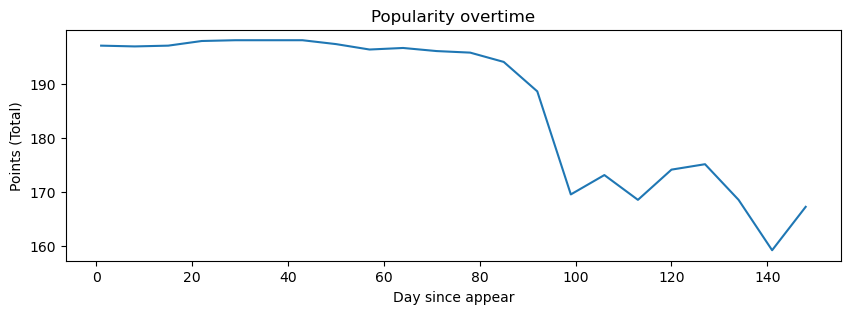

In [56]:
sample = df_clean.sample(n=1).iloc[0]
# sample = df_clean[df_clean["id"] == "62aP9fBQKYKxi7PDXwcUAS"].iloc[0]
df_focus = df_clean[df_clean["id"] == sample["id"]]

print(f'id: {sample["id"]} | Total count: {df_focus.shape[0]}')
print(f'Song: {sample["Title"]} | Artists: {sample["Artists"]} | Continent: {sample["Continent"]}')

# # Histogram
# plt.figure(figsize=(10, 3))
# sns.histplot(df_focus["Date"], bins=50)

# # Popularity over time
# plt.show()
# plt.figure(figsize=(10, 3))
# sns.lineplot(data=df_focus, x="Date", y="Points (Total)")

plt.show()
plt.figure(figsize=(10,3))
sns.lineplot(data=pivot_df.loc[sample["id"]])
plt.title("Popularity overtime")
plt.ylabel("Points (Total)")
plt.xlabel("Day since appear")

plt.show()
plt.figure(figsize=(10,3))
last_zero = np.nonzero(pivot_df.loc[sample["id"]].values)[0][-1]
sns.lineplot(data=pivot_df.loc[sample["id"]][:last_zero])
plt.title("Popularity overtime")
plt.ylabel("Points (Total)")
plt.xlabel("Day since appear")

# Clustering

In [19]:
# # df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
# df_cluster_original = pivot_df.copy()

# dbscan = DBSCAN(eps=100)
# dbscan.fit(df_cluster_original)

# df_cluster = df_cluster_original.copy()
# df_cluster['cluster'] = dbscan.labels_
# labels = dbscan.labels_

# # pca = PCA(n_components=4)  # Reduce to 2 dimensions
# # X_2d = pca.fit_transform(df_cluster_original)

# # plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')

# plt.figure(figsize=(8, 3))
# sns.histplot(df_cluster["cluster"])

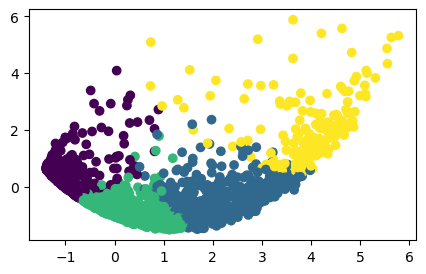

<Axes: xlabel='cluster', ylabel='Count'>

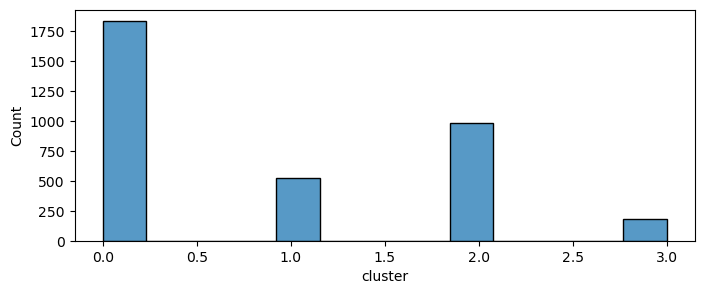

In [20]:
# df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
df_cluster_original = pivot_df_norm.copy()

kmeans = KMeans(n_clusters=4, n_init="auto", max_iter=300)
kmeans.fit(df_cluster_original)

df_cluster = df_cluster_original.copy()
df_cluster['cluster'] = kmeans.labels_
pivot_df['cluster'] = kmeans.labels_ # RESULT to original HERE
labels = kmeans.labels_

pca = PCA(n_components=2)  # Reduce to 2 dimensions
X_2d = pca.fit_transform(df_cluster_original)
plt.figure(figsize=(5, 3))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')
plt.show()

plt.figure(figsize=(8, 3))
sns.histplot(df_cluster["cluster"])

In [21]:
# # Cluster 2nd
# df_cluster2 = df_cluster.groupby("cluster").mean().reset_index()

# kmeans = KMeans(n_clusters=3, n_init="auto", max_iter=300)
# kmeans.fit(df_cluster2.drop(columns="cluster"))
# df_cluster2['cluster2'] = kmeans.labels_

# plt.figure(figsize=(8, 3))
# sns.histplot(df_cluster2["cluster2"])
# plt.show()

# # Join cluster2 into cluster 1
# df_cluster_join = df_cluster.join(df_cluster2[["cluster", "cluster2"]].set_index("cluster"), on="cluster")
# df_cluster_join['cluster'] = df_cluster_join['cluster2']
# df_cluster_join.drop(columns='cluster2', inplace=True)
# df_cluster = df_cluster_join
# plt.figure(figsize=(8, 3))
# sns.histplot(df_cluster["cluster"])

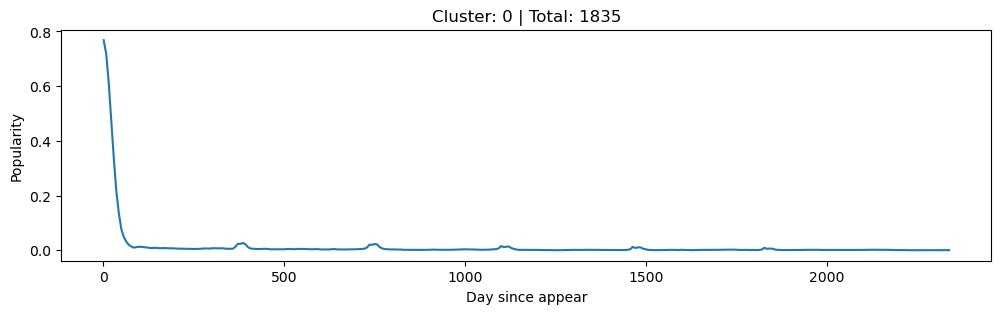

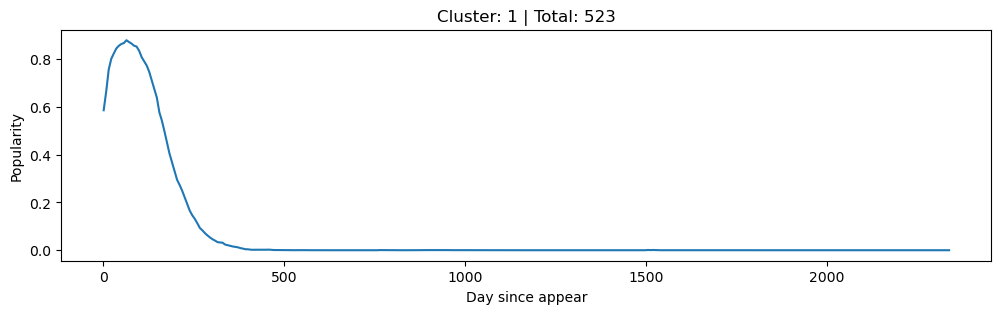

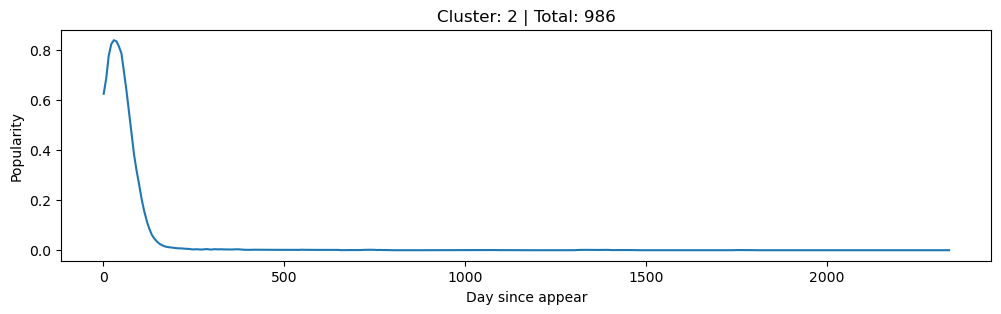

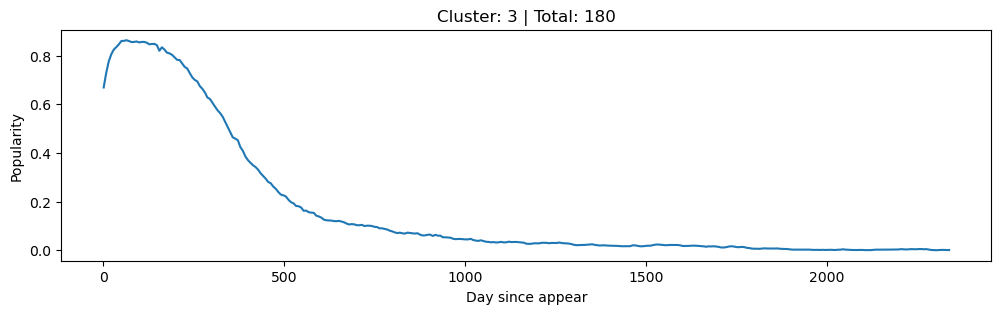

In [22]:
for cluster in sorted(df_cluster["cluster"].unique()):
    cluster_size = df_cluster[df_cluster["cluster"] == cluster].shape[0]
#     sample = pivot_df[df_cluster["cluster"] == cluster]
    sample = df_cluster[df_cluster["cluster"] == cluster]
    df_sample = sample.drop(columns="cluster").mean()

    plt.figure(figsize=(12, 3))
    ax = sns.lineplot(df_sample.T)
    ax.set_title(f'Cluster: {cluster} | Total: {cluster_size}')
    ax.set(xlabel='Day since appear', ylabel='Popularity')
    plt.show()

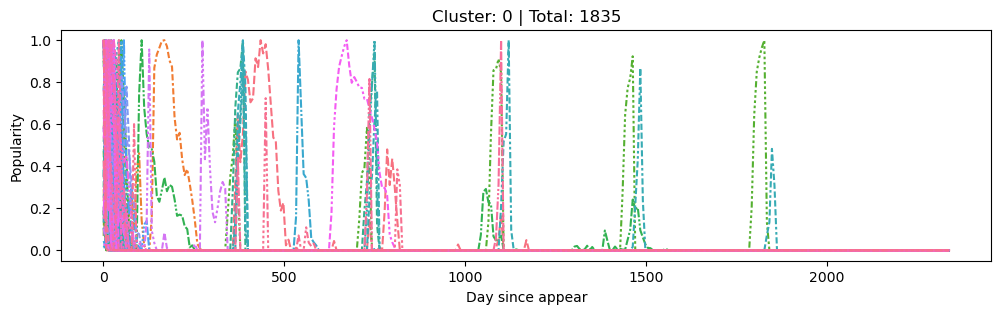

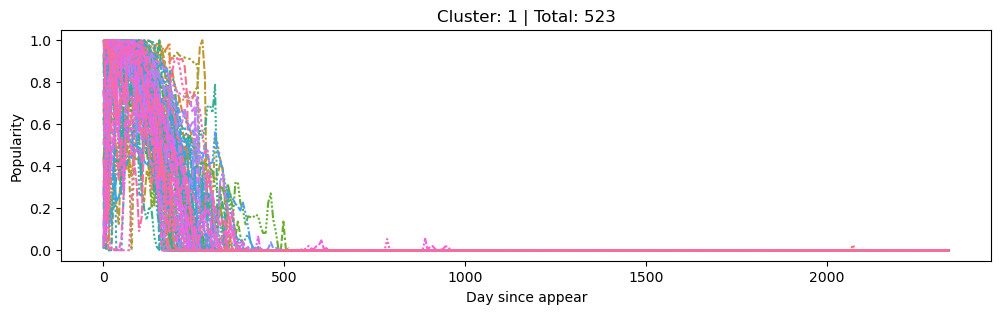

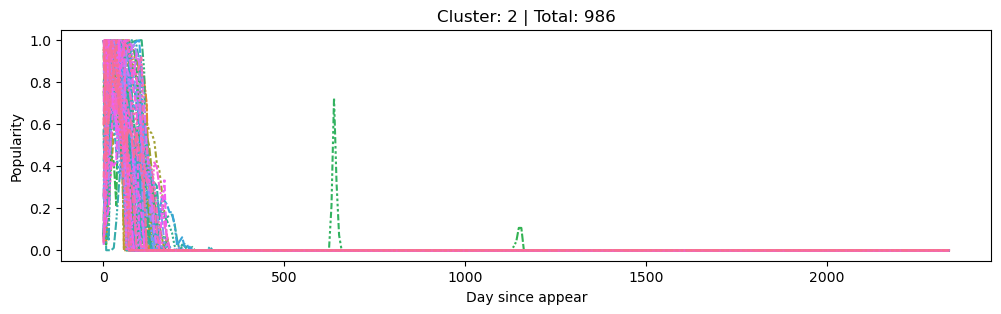

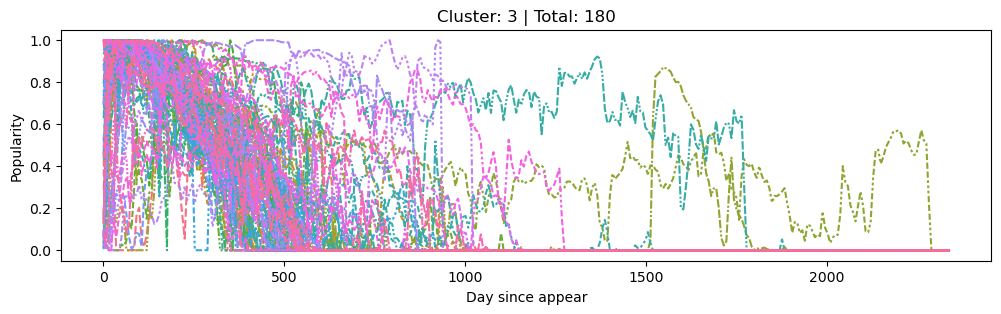

In [23]:
for cluster in sorted(df_cluster["cluster"].unique()):
    cluster_size = df_cluster[df_cluster["cluster"] == cluster].shape[0]
    sample = df_cluster[df_cluster["cluster"] == cluster].sample(min(cluster_size, 100))
#     sample = pivot_df[df_cluster["cluster"] == cluster].sample(min(cluster_size, 100))
    df_sample = sample.drop(columns="cluster")

    plt.figure(figsize=(12, 3))
    ax = sns.lineplot(df_sample.T)
    ax.set_title(f'Cluster: {cluster} | Total: {cluster_size}')
    ax.set(xlabel='Day since appear', ylabel='Popularity')
    ax.get_legend().remove()
    plt.show()

In [30]:
df_cluster

day_since_appear,1,8,15,22,29,36,43,50,57,64,...,2283,2290,2297,2304,2311,2318,2325,2332,2339,cluster
id,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,0.996230,0.992460,1.000000,0.969840,0.898209,0.951932,0.951932,0.917059,0.872762,0.839774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
003vvx7Niy0yvhvHt4a68B,0.086598,0.026804,0.014433,0.028866,0.002062,0.004124,0.000000,0.000000,0.016495,0.014433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
00Blm7zeNqgYLPtW6zg8cj,1.000000,0.984456,0.958549,0.934123,0.892672,0.792006,0.786084,0.660252,0.741673,0.856403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
00EPIEnX1JFjff8sC6bccd,0.083696,0.375000,0.686957,0.685870,0.813043,0.871739,0.998913,1.000000,0.996739,0.961957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
00ko9WaS4jOX1kEk3gvHjf,0.784131,1.000000,0.358226,0.001167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7yq4Qj7cqayVTp3FF9CWbm,0.009831,0.004213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7ytR5pFWmSjzHJIeQkgog4,0.960000,0.937143,0.927857,0.965000,0.981429,0.994286,0.994286,0.999286,0.999286,0.998571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
7yyRTcZmCiyzzJlNzGC9Ol,1.000000,0.912605,0.901681,0.873950,0.814286,0.796639,0.768067,0.731933,0.578151,0.578992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [129]:
# inspect each cluster, 7, 8 , 27
# ids_to_be_used = df_cluster[df_cluster["cluster"] == 27].index
# df_clean[df_clean["id"].isin(ids_to_be_used)].groupby("id").first()

# RandomForestClassifier

In [21]:
# Join cluster label back to the original data
features = ['Danceability', 'Energy',
       'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence']
df_songs = df_clean.groupby("id").first()[features].copy()
df_songs = df_songs.join(df_cluster[["cluster"]], on='id')
# df_songs

In [22]:
X = df_songs[features]
y = df_songs['cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

[[290  26  40   0]
 [ 81   5  18   2]
 [158   7  37   1]
 [ 33   1   5   1]]
R2.     :  -0.7415355107802364
Accuracy:  0.4723404255319149
Recall  :  0.4723404255319149


<Axes: >

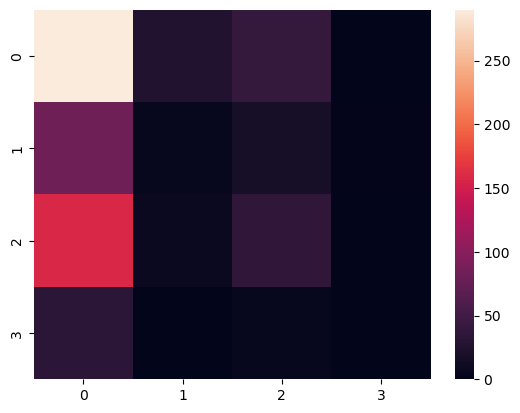

In [23]:
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print("R2.     : ", r2_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall  : ", recall_score(y_test, y_pred, average="micro"))
# print("F1      : ", f1_score(y_test, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
# fig = plt.figure(figsize=(12, 12))
sns.heatmap(df_cm)

# Clustering (Draft, TimeSeriesKMeans)

In [46]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 8.5 MB/s eta 0:00:00a 0:00:01


In [47]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
# df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
df_cluster_original = df_diff.copy()


km = TimeSeriesKMeans(n_clusters=10, metric="dtw")
labels = km.fit_predict(df_cluster_original)

df_cluster = df_cluster_original.copy()
df_cluster['cluster'] = labels

plt.figure(figsize=(6, 3))
sns.histplot(df_cluster["cluster"])

# Visualise Correlation

In [150]:
df_result = df_clean.drop_duplicates(subset=["id"], keep="last")
df_result = df_result.join(df_cluster[["cluster"]], on='id')
df_result = df_result.join(df_appear_count.set_index('id'), on='id')

df_result = df_result[['id', 'Danceability', 'Energy',
       'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', 'cluster', 'count']].copy()

Text(0.5, 149.72222222222223, 'Cluster')

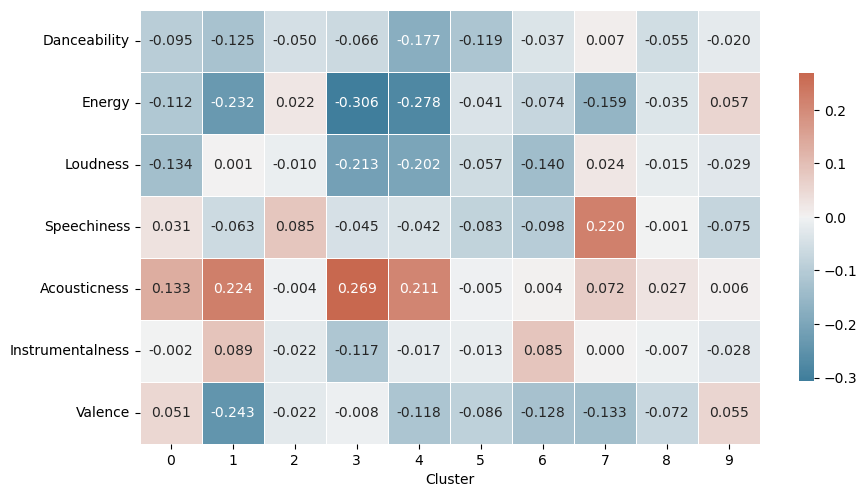

In [151]:
df_raw = df_result.drop(columns=['id']).copy()
df_corr_clus = pd.DataFrame()

for clus in sorted(df_raw["cluster"].unique()):
    df_corr = df_raw[df_raw["cluster"] == clus].drop(columns="cluster").corr()
    df_corr_clus[clus] = df_corr[["count"]].T.drop(columns="count").iloc[0]

# Draw the heatmap
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap((df_corr_clus), cmap=cmap, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.3f')

plt.xlabel("Cluster")